In [1]:
import os

In [2]:
os.chdir("../")

In [3]:
%pwd

'/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep'

# Configure config.yaml which holds information about where our data will be stored

In [ ]:
# Configuration related to bertopic thematic clustering
ber_topic:
  # Root directory for training artifacts
  root_dir: artifacts/model_training/bertopic_thematic

  # Path to enriched train dataset
  data_path:  artifacts/data_transformation/merged_train_data.csv
  
  # Path to save enriched dataset
  output_path: artifacts/model_training/bertopic_thematic/output



Entity Config

In [4]:
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Any

@dataclass
class BERTopicConfig:
    root_dir: Path
    data_path: Path
    output_path: Path


Configuration manager

In [5]:
from src.career_chief.constants import *
from src.career_chief.utils.common import read_yaml, create_directories
from src.career_chief import logger
from src.career_chief.entity.config_entity import (DataIngestionConfig, DataValidationConfig, SpacyNERConfig, BERTopicConfig)

class ConfigurationManager:
    """
    ConfigurationManager manages configurations needed for the data pipeline.

    The class reads configuration, parameter, and schema settings from specified files
    and provides a set of methods to access these settings. It also takes care of
    creating necessary directories defined in the configurations.

    Attributes:
    - config (dict): Configuration settings.
    - params (dict): Parameters for the pipeline.
    - schema (dict): Schema information.
    """
    
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH, 
                 params_filepath = PARAMS_FILE_PATH, 
                 schema_filepath = SCHEMA_FILE_PATH) -> None:
        """
        Initialize ConfigurationManager with configurations, parameters, and schema.

        Args:
        - config_filepath (Path): Path to the configuration file.
        - params_filepath (Path): Path to the parameters file.
        - schema_filepath (Path): Path to the schema file.

        Creates:
        - Directories specified in the configuration.
        """
        self.config = self._read_config_file(config_filepath, "config")
        self.params = self._read_config_file(params_filepath, "params")
        self.schema = self._read_config_file(schema_filepath, "schema")

        # Create the directory for storing artifacts if it doesn't exist
        create_directories([self.config.artifacts_root])

    def _read_config_file(self, filepath: str, config_name: str) -> dict:
        """
        Read a configuration file and return its content.

        Args:
        - filepath (str): Path to the configuration file.
        - config_name (str): Name of the configuration (for logging purposes).

        Returns:
        - dict: Configuration settings.

        Raises:
        - Exception: If there's an error reading the file.
        """
        try:
            return read_yaml(filepath)
        except Exception as e:
            logger.error(f"Error reading {config_name} file: {filepath}. Error: {e}")
            raise

    
    def get_ber_topic_config(self) -> BERTopicConfig:
        
        try:
            ber_topic_config = self.config['ber_topic']
            
            return BERTopicConfig(
                root_dir=Path(ber_topic_config['root_dir']),
                data_path=Path(ber_topic_config['data_path']),
                output_path=Path(ber_topic_config['output_path']),
            )
        except KeyError as e:
            logger.error(f"A required configuration is missing in the 'ber_topic_config' section: {e}")
            raise KeyError(f"Missing configuration in 'ber_topic_config': {e}") from e

Component

In [39]:
from IPython.display import display, HTML
import pandas as pd
from pathlib import Path
from bertopic import BERTopic
from tqdm.auto import tqdm
from src.career_chief import logger

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

class ThematicClustering:
    def __init__(self, config):
        """
        Initializes the ThematicClustering with necessary configuration settings.
        
        Parameters:
            config (BERTopicConfig): Configuration object containing paths and settings.
        """
        self.config = config
        self.model = BERTopic()  # Initialize the BERTopic model

    def load_data(self):
        """
        Loads the data from a specified CSV file path.
        
        Returns:
            pd.DataFrame: Loaded data.
        """
        logger.info(f"Loading data from {self.config.data_path}.")
        return pd.read_csv(self.config.data_path)
    
    def filter_data(self, data, job_titles=None, num_jobs=10):
        """
        Filters the dataset to include only entries from a specified list of job titles or a set number of unique jobs.
        Filtering process is displayed with a progress bar.

        Parameters:
            data (pd.DataFrame): The loaded dataset.
            job_titles (list, optional): List of specific job titles to include.
            num_jobs (int, optional): Number of unique jobs to randomly select if job_titles is not provided.

        Returns:
            pd.DataFrame: The filtered dataset.
        """
        if job_titles:
            filtered_data = data[data['title'].isin(job_titles)]
        else:
            # Randomly select unique jobs if no specific titles are provided
            selected_jobs = data['title'].dropna().sample(n=num_jobs, random_state=42).tolist()
            filtered_data = data[data['title'].isin(selected_jobs)]
        
        logger.info(f"Filtered data to include {len(filtered_data)} entries from specified job titles or random selection.")
        return filtered_data
    
    def save_results(self, data):
        """
        Saves the clustering results and the model.
        """
        output_file = Path(self.config.output_path) / "clustering_results.csv"
        data.to_csv(output_file, index=False)
        self.model.save(Path(self.config.output_path) / "bertopic_model")
        logger.info(f"Clustering results and model saved to {self.config.output_path}.")

    def perform_clustering(self, column_name):
        """
        Performs thematic clustering on a specified column from the loaded data,
        including probabilities associated with each topic assignment.
        Clustering progress is tracked with a progress bar.

        Parameters:
            column_name (str): The column of the dataframe to perform clustering on.
        """
        data = self.load_data()
        filtered_data = data.copy()
        texts = filtered_data[column_name].dropna().astype(str)  # Ensure text data is in the correct format
        
        # Reset the index after filtering to align it with the number of entries
        filtered_data = filtered_data.loc[texts.index].reset_index(drop=True)

        logger.info("Starting thematic clustering.")
        topics, probabilities = self.model.fit_transform(texts.tolist())

        # Safely handle probabilities
        if probabilities.ndim > 1 and probabilities.shape[1] > 1:
            max_probabilities = probabilities.max(axis=1)
        else:
            max_probabilities = probabilities.flatten()

        filtered_data['topic'] = topics
        filtered_data['probability'] = max_probabilities  # Save the highest probability per document

        # Save the model and results
        self.save_results(filtered_data)
        logger.info("Thematic clustering completed and results saved.")


    def run(self, column_name):
        """
        Executes the thematic clustering process on the specified column of the dataset.

        Parameters:
            column_name (str): Name of the column to perform clustering on.
        """
        logger.info("Running the Thematic Clustering pipeline.")
        self.perform_clustering(column_name)
        # self.visualize_topics()
        logger.info("Thematic Clustering pipeline completed successfully.")


In [40]:
from src.career_chief import logger
from src.career_chief.config.configuration import ConfigurationManager
# from src.career_chief.components.thematic_clustering import ThematicClustering

class ThematicClusteringPipeline:
    """
    This pipeline orchestrates the thematic clustering of text data using BERTopic.
    
    It manages the entire process from configuration loading, model initialization, 
    to the execution of thematic clustering and result saving.
    """
    
    STAGE_NAME = "Thematic Clustering Pipeline"

    def __init__(self):
        """
        Initializes the pipeline with the ConfigurationManager instance
        to access the necessary configurations for thematic clustering.
        """
        self.config_manager = ConfigurationManager()
        logger.info(f"{self.STAGE_NAME} initialized successfully.")

    def run_thematic_clustering(self):
        """
        Executes the thematic clustering process by:
        - Fetching configuration
        - Initializing the thematic clustering component
        - Running the clustering process
        """
        try:
            logger.info(f"{self.STAGE_NAME}: Fetching model configuration.")
            thematic_clustering_config = self.config_manager.get_ber_topic_config()

            logger.info(f"{self.STAGE_NAME}: Initializing the ThematicClustering component.")
            thematic_clustering = ThematicClustering(config=thematic_clustering_config)

            logger.info(f"{self.STAGE_NAME}: Executing the thematic clustering pipeline.")
            thematic_clustering.run('cleaned_text')  # Assumes 'cleaned_text' is the column to cluster

            logger.info(f"{self.STAGE_NAME}: Thematic clustering pipeline executed successfully.")

        except Exception as e:
            logger.error(f"{self.STAGE_NAME}: Error occurred during thematic clustering - {str(e)}")
            raise e


In [41]:
if __name__ == '__main__':
    pipeline = ThematicClusteringPipeline()
    pipeline.run_thematic_clustering()
    

[2024-04-14 16:56:25,700: 41: career_chief_logger: INFO: common:  yaml file: config/config.yaml loaded successfully]
[2024-04-14 16:56:25,736: 41: career_chief_logger: INFO: common:  yaml file: params.yaml loaded successfully]
[2024-04-14 16:56:25,740: 41: career_chief_logger: INFO: common:  yaml file: schema.yaml loaded successfully]
[2024-04-14 16:56:25,746: 64: career_chief_logger: INFO: common:  Created directory at: artifacts]
[2024-04-14 16:56:25,748: 21: career_chief_logger: INFO: 1117121342:  Thematic Clustering Pipeline initialized successfully.]
[2024-04-14 16:56:25,748: 31: career_chief_logger: INFO: 1117121342:  Thematic Clustering Pipeline: Fetching model configuration.]
[2024-04-14 16:56:25,763: 34: career_chief_logger: INFO: 1117121342:  Thematic Clustering Pipeline: Initializing the ThematicClustering component.]
[2024-04-14 16:56:26,181: 37: career_chief_logger: INFO: 1117121342:  Thematic Clustering Pipeline: Executing the thematic clustering pipeline.]
[2024-04-14 16

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISMTOKENIZERS_PARALLELISMTOKENIZERS_PARALLELISM=(true | false)
=(true | false)
=(true | false)
huggingface/tokenizers: The 

[2024-04-14 19:17:25,998: 64: career_chief_logger: INFO: 2953676875:  Clustering results and model saved to artifacts/model_training/bertopic_thematic/output.]
[2024-04-14 19:17:26,006: 96: career_chief_logger: INFO: 2953676875:  Thematic clustering completed and results saved.]
[2024-04-14 19:17:27,704: 109: career_chief_logger: INFO: 2953676875:  Thematic Clustering pipeline completed successfully.]
[2024-04-14 19:17:27,706: 40: career_chief_logger: INFO: 1117121342:  Thematic Clustering Pipeline: Thematic clustering pipeline executed successfully.]


# Looking closely at the clustering results dataframe

In [54]:
clustering_results = pd.read_csv('artifacts/model_training/bertopic_thematic/output/clustering_results.csv')

In [55]:
clustering_results.head(5)

Unnamed: 0  index                title       company_name  location  \
0       30200    827  Senior Data Analyst  Planet Technology  Anywhere   
1       30200    827  Senior Data Analyst  Planet Technology  Anywhere   
2       30200    827  Senior Data Analyst  Planet Technology  Anywhere   
3       30200    827  Senior Data Analyst  Planet Technology  Anywhere   
4       30200    827  Senior Data Analyst  Planet Technology  Anywhere   

            via                                        description  \
0  via LinkedIn  Our Client is looking for a full-time Sr. Data...   
1  via LinkedIn  Our Client is looking for a full-time Sr. Data...   
2  via LinkedIn  Our Client is looking for a full-time Sr. Data...   
3  via LinkedIn  Our Client is looking for a full-time Sr. Data...   
4  via LinkedIn  Our Client is looking for a full-time Sr. Data...   

                                        extensions  \
0  ['10 hours ago', 'Work from home', 'Full-time']   
1  ['10 hours ago', 'Work from home', 'Full-time']   
2  ['10 hours ago', 'Work from home', 'Full-time']   
3  ['10 hours ago', 'Work from home', 'Full-time']   
4  ['10 hours ago', 'Work from home', 'Full-time']   

                                              job_id  \
0  eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...   
1  eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...   
2  eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...   
3  eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...   
4  eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...   

                                           thumbnail  ... salary_yearly  \
0  https://encrypted-tbn0.gstatic.com/images?q=tb...  ...           NaN   
1  https://encrypted-tbn0.gstatic.com/images?q=tb...  ...           NaN   
2  https://encrypted-tbn0.gstatic.com/images?q=tb...  ...           NaN   
3  https://encrypted-tbn0.gstatic.com/images?q=tb...  ...           NaN   
4  https://encrypted-tbn0.gstatic.com/images?q=tb...  ...           NaN   

  salary_standardized                                 description_tokens  \
0                 NaN  ['excel', 'bigquery', 'redshift', 'sql', 'powe...   
1                 NaN  ['excel', 'bigquery', 'redshift', 'sql', 'powe...   
2                 NaN  ['excel', 'bigquery', 'redshift', 'sql', 'powe...   
3                 NaN  ['excel', 'bigquery', 'redshift', 'sql', 'powe...   
4                 NaN  ['excel', 'bigquery', 'redshift', 'sql', 'powe...   

                                        cleaned_text  \
0  Our Client is looking for a fulltime Sr Data A...   
1  Our Client is looking for a fulltime Sr Data A...   
2  Our Client is looking for a fulltime Sr Data A...   
3  Our Client is looking for a fulltime Sr Data A...   
4  Our Client is looking for a fulltime Sr Data A...   

                                              tokens  \
0  ['Our', 'C', '##lient', 'is', 'looking', 'for'...   
1  ['Our', 'C', '##lient', 'is', 'looking', 'for'...   
2  ['Our', 'C', '##lient', 'is', 'looking', 'for'...   
3  ['Our', 'C', '##lient', 'is', 'looking', 'for'...   
4  ['Our', 'C', '##lient', 'is', 'looking', 'for'...   

                                         ner_results  \
0  [{'entity': 'B-MISC', 'score': 0.6366868, 'ind...   
1  [{'entity': 'B-MISC', 'score': 0.6366868, 'ind...   
2  [{'entity': 'B-MISC', 'score': 0.6366868, 'ind...   
3  [{'entity': 'B-MISC', 'score': 0.6366868, 'ind...   
4  [{'entity': 'B-MISC', 'score': 0.6366868, 'ind...   

                                         entity_text  \
0                                    Sr Data Analyst   
1                                       Data Analyst   
2                                  critical thinking   
3  thought partner to the stakeholder community a...   
4                                   Looker Excel etc   

                  entity_label topic probability  
0                    Job Title  4755    1.000000  
1                    Job Title  4755    0.748666  
2                  Soft Skills  4755    1.000000  
3  Duties and R

In [57]:
empty_columns = clustering_results.isnull().all(axis=0)
empty_columns

Unnamed: 0             False
index                  False
title                  False
company_name           False
location               False
via                    False
description            False
extensions             False
job_id                 False
thumbnail              False
posted_at              False
schedule_type          False
work_from_home         False
salary                 False
search_term            False
date_time              False
search_location        False
commute_time            True
salary_pay             False
salary_rate            False
salary_avg             False
salary_min             False
salary_max             False
salary_hourly          False
salary_yearly          False
salary_standardized    False
description_tokens     False
cleaned_text           False
tokens                 False
ner_results            False
entity_text            False
entity_label           False
topic                  False
probability            False
dtype: bool

# Visualize Model 

In [ ]:
from bertopic import BERTopic
from pathlib import Path
import plotly.graph_objects as go
from src.career_chief import logger

class ThematicVisualization:
    def __init__(self, model_path, output_path):
        self.model_path = Path(model_path)
        self.output_path = Path(output_path)
        try:
            self.model = BERTopic.load(str(self.model_path))
        except Exception as e:
            logger.error(f"Failed to load BERTopic model: {e}")
            raise

    def save(self, fig, filename):
        """ Saves visualization in HTML format."""
        file_path = self.output_path / f"{filename}.html"
        fig.write_html(str(file_path))
        logger.info(f"Visualization saved to {file_path}")

    def visualize_topics(self):
        """Visualizes the clusters of topics."""
        logger.info("Visualizing topics...")
        fig = self.model.visualize_topics()
        self.save(fig, 'topics_visualization')
        fig.show()

    def visualize_barchart(self):
        """Visualizes the bar chart of the most frequent terms in each topic."""
        logger.info("Visualizing bar chart...")
        fig = self.model.visualize_barchart()
        self.save(fig, 'barchart_visualization')
        fig.show()

    def run_all_visualizations(self):
        """Runs selected visualizations."""
        logger.info("Starting all visualizations.")
        self.visualize_topics()  # Visualize intertopic distance map
        self.visualize_barchart()  # Visualize the bar chart of term frequencies
        logger.info("All visualizations completed successfully.")



In [27]:
# Usage
if __name__ == '__main__':
    visualization = ThematicVisualization(
        model_path='artifacts/model_training/bertopic_thematic/output/bertopic_model',
        output_path='artifacts/model_training/bertopic_thematic/output'
    )
    visualization.run_all_visualizations()

[2024-04-14 13:08:52,783: 38: career_chief_logger: INFO: 3685632361:  Starting all visualizations.]
[2024-04-14 13:08:52,783: 24: career_chief_logger: INFO: 3685632361:  Visualizing topics...]
[2024-04-14 13:08:54,228: 20: career_chief_logger: INFO: 3685632361:  Visualization saved to artifacts/model_training/bertopic_thematic/output/topics_visualization.html]


[2024-04-14 13:08:54,394: 31: career_chief_logger: INFO: 3685632361:  Visualizing bar chart...]
[2024-04-14 13:08:54,449: 20: career_chief_logger: INFO: 3685632361:  Visualization saved to artifacts/model_training/bertopic_thematic/output/barchart_visualization.html]


[2024-04-14 13:08:54,452: 41: career_chief_logger: INFO: 3685632361:  All visualizations completed successfully.]


# Visualize Model applied on Train Data

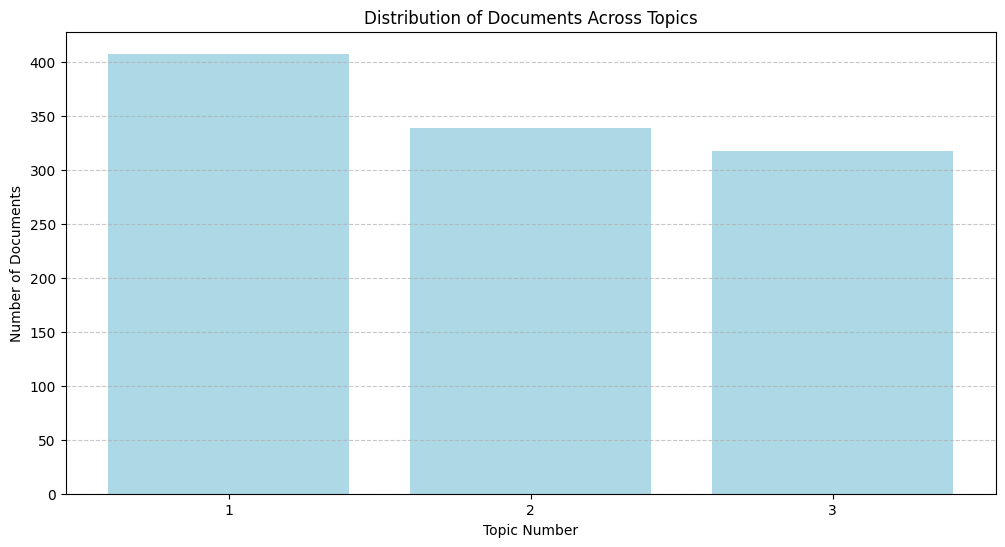

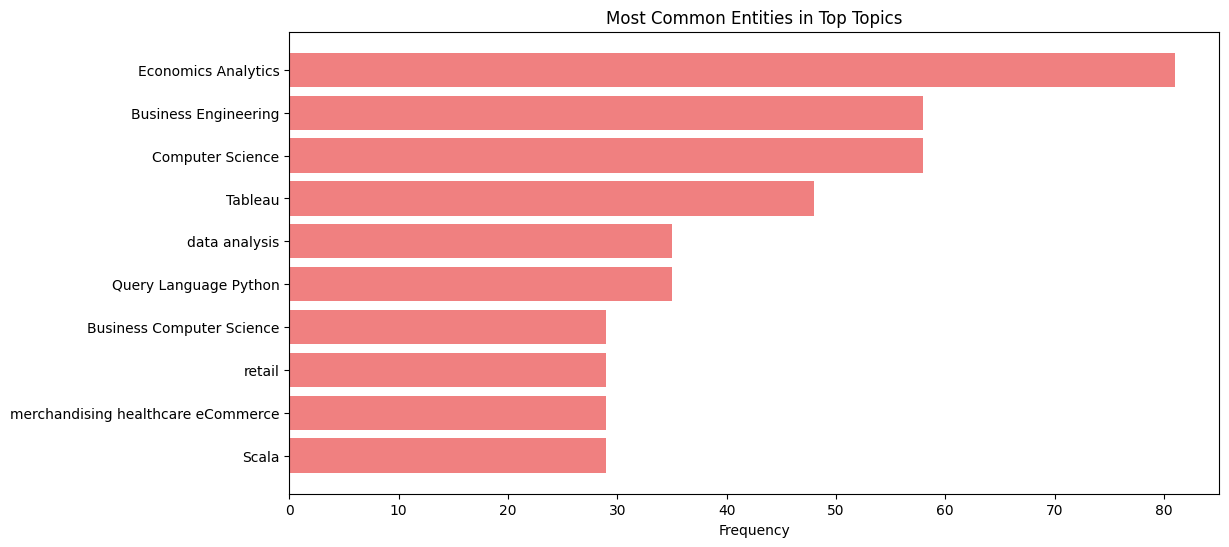

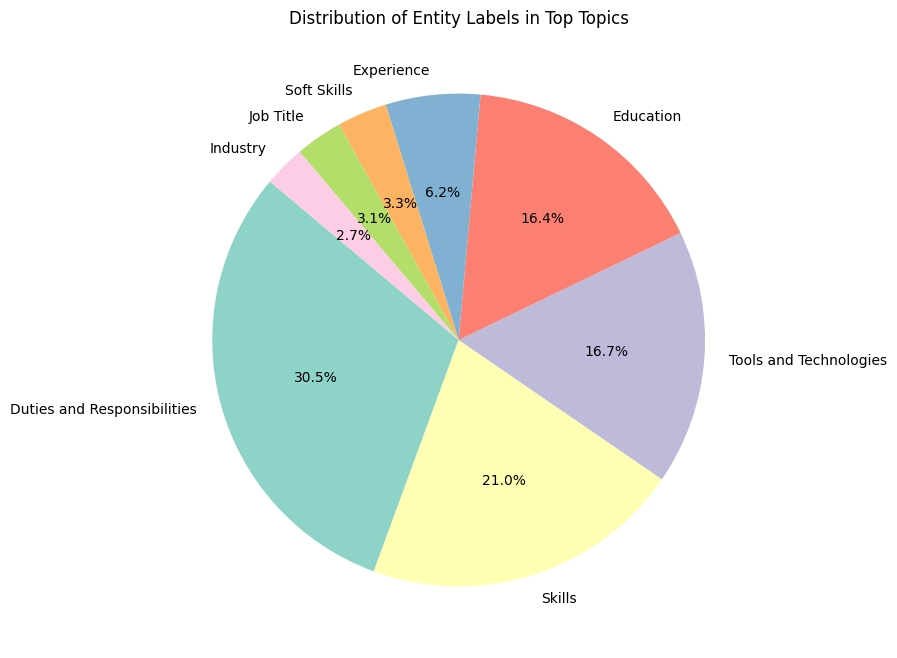

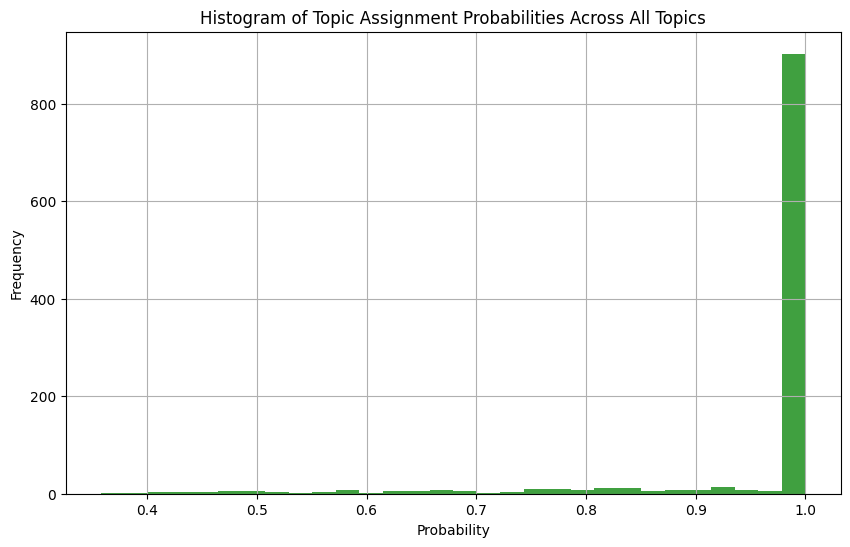

In [52]:
from collections import Counter

updated_data = pd.read_csv('artifacts/model_training/bertopic_thematic/output/clustering_results_filtered_123.csv')

# Display the first few rows of the dataset and column names to understand its structure and contents
updated_data.head(), updated_data.columns

# Distribution of topics
topic_distribution = Counter(updated_data['topic'])

# Visualize the distribution of topics
plt.figure(figsize=(12, 6))
plt.bar(topic_distribution.keys(), topic_distribution.values(), color='lightblue')
plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.title('Distribution of Documents Across Topics')
plt.xticks(list(topic_distribution.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Prepare to examine common entities and labels for selected topics (for example, top 3 topics)
top_topics = sorted(topic_distribution, key=topic_distribution.get, reverse=True)[:3]
top_topics_data = updated_data[updated_data['topic'].isin(top_topics)]

# Analyze most common entities and labels in top topics
top_entities = Counter(top_topics_data['entity_text'])
common_entities_top_topics = top_entities.most_common(10)
top_labels = Counter(top_topics_data['entity_label'])
common_labels_top_topics = top_labels.most_common()

common_entities_top_topics, common_labels_top_topics


# Visualization: Bar Chart of Most Common Entities in Top Topics
entities_top, counts_top = zip(*common_entities_top_topics)
plt.figure(figsize=(12, 6))
plt.barh(entities_top, counts_top, color='lightcoral')
plt.xlabel('Frequency')
plt.title('Most Common Entities in Top Topics')
plt.gca().invert_yaxis()
plt.show()

# Visualization: Pie Chart of Entity Labels Distribution in Top Topics
labels_top, label_counts_top = zip(*common_labels_top_topics)
plt.figure(figsize=(8, 8))
plt.pie(label_counts_top, labels=labels_top, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title('Distribution of Entity Labels in Top Topics')
plt.show()

# Visualization: Histogram of Topic Assignment Probabilities for all topics
plt.figure(figsize=(10, 6))
plt.hist(updated_data['probability'], bins=30, color='green', alpha=0.75)
plt.title('Histogram of Topic Assignment Probabilities Across All Topics')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()




# Results Analysis

In [45]:
import pandas as pd

# Load the data from the CSV files
topic_info_path = '/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/model_training/bertopic_thematic/output/topic_info.csv'
term_frequencies_path = '/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/model_training/bertopic_thematic/output/term_frequencies.csv'

# Read the files into pandas DataFrames
topic_info_df = pd.read_csv(topic_info_path)
term_frequencies_df = pd.read_csv(term_frequencies_path)

# Display the first few rows of each DataFrame to understand their structure
topic_info_df.head(), term_frequencies_df.head()

(   Topic  Count                                           Name  \
 0     -1    287                -1_product_market_cox_aerospace   
 1      0    886               0_quality_requires_practices_kdd   
 2      1    408  1_transportation_shipment_improvement_walmart   
 3      2    339             2_youll_implement_dataiku_improved   
 4      3    318       3_understands_supply_educates_translates   
 
                                       Representation  \
 0  ['product', 'market', 'cox', 'aerospace', 'est...   
 1  ['quality', 'requires', 'practices', 'kdd', 's...   
 2  ['transportation', 'shipment', 'improvement', ...   
 3  ['youll', 'implement', 'dataiku', 'improved', ...   
 4  ['understands', 'supply', 'educates', 'transla...   
 
                                  Representative_Docs  
 0  ['Reports to Director of Product Strategy  Man...  
 1  ['Position Summary\n\nWhat youll do\n\nData So...  
 2  ['Position Summary\n\nWhat youll do\n\nLead th...  
 3  ['Position Summary\n\nWh

In [46]:
# Display the topics sorted by document count in descending order to identify the top topics
top_topics = topic_info_df.sort_values('Count', ascending=False)
top_topics.head()


Topic  Count                                           Name  \
1      0    886               0_quality_requires_practices_kdd   
2      1    408  1_transportation_shipment_improvement_walmart   
3      2    339             2_youll_implement_dataiku_improved   
4      3    318       3_understands_supply_educates_translates   
0     -1    287                -1_product_market_cox_aerospace   

                                      Representation  \
1  ['quality', 'requires', 'practices', 'kdd', 's...   
2  ['transportation', 'shipment', 'improvement', ...   
3  ['youll', 'implement', 'dataiku', 'improved', ...   
4  ['understands', 'supply', 'educates', 'transla...   
0  ['product', 'market', 'cox', 'aerospace', 'est...   

                                 Representative_Docs  
1  ['Position Summary\n\nWhat youll do\n\nData So...  
2  ['Position Summary\n\nWhat youll do\n\nLead th...  
3  ['Position Summary\n\nWhat youll do\n\nAre you...  
4  ['Position Summary\n\nWhat youll do\n\nAs a Se...  
0  ['Reports to Director of Product Strategy  Man...

In [47]:
# Extract representative documents for the top two topics (Topic 0 and Topic 1)
representative_docs_topic_0 = top_topics.iloc[0]['Representative_Docs']
representative_docs_topic_1 = top_topics.iloc[1]['Representative_Docs']

# Display the representative documents for better insight
representative_docs_topic_0, representative_docs_topic_1


("['Position Summary\\n\\nWhat youll do\\n\\nData Source Identification Requires knowledge of Functional business domain and scenarios Categories of data and where it is held Business data requirements Database technologies and distributed datastores eg Structured Query Language Not Only SQL Data Quality Existing business systems and processes including the key drivers and measures of success To support the understanding of the priority order of requirements and service level agreements Help identify the most suitable source for data that is fit for purpose Perform initial data quality checks on extracted data\\n\\nData Strategy Requires knowledge of understanding of business value and relevance of data and data enabled insights  decisions Appropriate application and understanding of data ecosystem including Data Management Data Quality Standards and Data Governance Accessibility Storage and Scalability etc Understanding of the methods and applications that unlock the monetary value of